# Quantum & Classical VaR / CVaR on **Returns**

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# For reproducibility in classical MC
rng = np.random.default_rng(12345)

## 1) Problem setup (distribution discretization)

We discretize a continuous return distribution onto `N = 2**NUM_QUBITS` grid points, and load it as an amplitude distribution.

In [ ]:
# Discretization / quantum register size
NUM_QUBITS = 9
N = 2**NUM_QUBITS

# Toy return distribution parameters (Gaussian)
mu, sigma = 0.15, 0.2

# Grid support (covers most mass for this toy)
SUPPORT = 4.0
grid_r = np.linspace(-SUPPORT, SUPPORT, N)      # increasing
pdf = stats.norm.pdf(grid_r, loc=mu, scale=sigma)
probs = pdf / pdf.sum()                         # sums to 1

# Tail definition: LEFT tail on returns
# alpha = 0.05 means 5th percentile of returns
ALPHA_DEFAULT = 0.05
TOL = ALPHA_DEFAULT / 10

## 2) Analytical VaR/CVaR for a Gaussian (benchmark)


In [ ]:
def analytical_var_cvar_normal(mu: float, sigma: float, alpha: float):
    q = stats.norm.ppf(alpha, loc=mu, scale=sigma)  # left-tail quantile
    z = (q - mu) / sigma
    phi = stats.norm.pdf(z)
    cvar = mu - sigma * (phi / alpha)  # left-tail conditional mean
    return float(q), float(cvar)

var_a, cvar_a = analytical_var_cvar_normal(mu, sigma, ALPHA_DEFAULT)
var_a, cvar_a

(-0.1789707253902946, -0.26254256150148503)

## 3) Classical Monte Carlo VaR/CVaR (benchmark)

We simulate returns, compute empirical `alpha`-quantile (VaR) and conditional mean below it (CVaR).

In [ ]:
def mc_var_cvar(mu: float, sigma: float, alpha: float, n_samples: int = 200_000, n_trials: int = 20, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    vars_, cvars_ = [], []
    for _ in range(n_trials):
        samples = rng.normal(loc=mu, scale=sigma, size=n_samples)
        q = np.quantile(samples, alpha)
        c = samples[samples <= q].mean()
        vars_.append(q)
        cvars_.append(c)
    return (float(np.mean(vars_)), float(np.std(vars_, ddof=1)),
            float(np.mean(cvars_)), float(np.std(cvars_, ddof=1)))

var_mc, var_mc_sd, cvar_mc, cvar_mc_sd = mc_var_cvar(mu, sigma, ALPHA_DEFAULT, rng=rng)
(var_mc, var_mc_sd, cvar_mc, cvar_mc_sd)

(-0.17936445624110073,
 0.0010715995679909556,
 -0.2628753934716338,
 0.0015270974177136408)

## 4) Quantum CVaR via **Classiq QSP/QSVT** (Fixed-point Amplitude Amplification)



In [ ]:
# ---- Classiq imports ----
from typing import Optional
from classiq import *
from classiq.execution import ExecutionPreferences, ExecutionSession
from classiq.applications.qsp import qsp_approximate, qsvt_phases

# -----------------------------
# QSP/QSVT knobs (tradeoffs)
# -----------------------------
# Degree of the QSP polynomial used in QSVT. Larger degree => closer to an ideal "sign" => stronger fixed-point amp.
DEGREE_DEFAULT = 25

# Slightly scale down the target polynomial for numerical stability when finding phases.
SCALE_DEFAULT = 0.95

# How many measurement shots to use when estimating CVaR from samples
NUM_SHOTS_DEFAULT = 4000

# Classiq synthesis width limit (tune if needed)
MAX_WIDTH = 28

probs_list = probs.tolist()  # Classiq wants a Python list


def build_fpaa_phases(min_overlap: float, degree: int = DEGREE_DEFAULT, scale: float = SCALE_DEFAULT, plot: bool = False):
    """
    Build a QSP-compatible polynomial approximation to the sign function on [min_overlap, 1],
    then convert it to QSVT phases using Classiq's helpers.

    In FPAA:
      - The relevant overlap is a = sqrt(p_tail).
      - We assume a >= min_overlap (a conservative lower bound).
      - The QSVT transformation approximately maps a -> ~1, amplifying the "good" subspace.
    """
    min_overlap = float(min_overlap)

    def target_function(x: float) -> float:
        # Sign(x) but scaled slightly below 1 for stability
        return float(scale * np.sign(x))

    pcoefs, max_err = qsp_approximate(
        f_target=target_function,
        degree=int(degree),
        parity=1,                # odd polynomial (as in the Classiq FPAA demo)
        interval=(min_overlap, 1),
        plot=plot,
    )
    phases = qsvt_phases(pcoefs)
    return phases, float(max_err), pcoefs


def classical_var_index(alpha: float) -> int:
    """
    VaR index for the *discretized* distribution.
    Smallest i such that sum_{k<=i} p_k >= alpha.
    """
    cdf = np.cumsum(probs)
    return int(np.searchsorted(cdf, alpha, side="left"))


def make_fpaa_tail_program(threshold_idx: int, phases):
    """
    Create a Classiq quantum program that:
      1) prepares |s> (the discretized return distribution),
      2) applies QSVT-based fixed-point amplitude amplification to boost the left-tail subspace,
      3) samples the index register (asset) and the QSVT aux qubit.
    """
    threshold_idx = int(threshold_idx)

    @qfunc
    def load_distribution(asset: QNum[NUM_QUBITS]):
        inplace_prepare_state(probabilities=probs_list, bound=0, target=asset)

    # Projector that identifies the prepared state |s> = A|0>.
    # Implementation pattern for a projector around A|0>:
    #   apply A†, check |0>, uncompute with A
    @qfunc
    def initial_state_projector(asset: QNum[NUM_QUBITS], aux: QBit):
        within_apply(
            within=lambda: invert(lambda: load_distribution(asset)),
            apply=lambda: inplace_xor(asset == 0, aux),
        )

    # Projector that identifies the TARGET (tail) subspace: i <= threshold_idx
    @qfunc
    def target_tail_projector(asset: QNum[NUM_QUBITS], aux: QBit):
        inplace_xor(asset <= threshold_idx, aux)

    @qfunc
    def main(asset: Output[QNum[NUM_QUBITS]], qsvt_aux: Output[QBit]):
        allocate(asset)
        load_distribution(asset)

        allocate(qsvt_aux)

        # QSVT with U = Identity, and projectors around |s> (domain) and tail subspace (image).
        qsvt(
            phase_seq=phases,
            proj_cnot_1=lambda _aux: initial_state_projector(asset, _aux),
            proj_cnot_2=lambda _aux: target_tail_projector(asset, _aux),
            u=lambda: IDENTITY(asset),
            aux=qsvt_aux,
        )
        # Outputs (asset, qsvt_aux) are measured by the classical ExecutionSession.sample()
    model = create_model(main)
    qprog = synthesize(model, constraints=Constraints(max_width=MAX_WIDTH))
    return qprog


def estimate_cvar_quantum_qsp(
    alpha: float = ALPHA_DEFAULT,
    degree: int = DEGREE_DEFAULT,
    min_overlap: 'Optional[float]' = None,
    shots: int = NUM_SHOTS_DEFAULT,
    plot_qsp: bool = False,
):
    """
    Estimate CVaR (left-tail mean return) using:
      - discretized VaR index (classical),
      - QSP/QSVT fixed-point amplitude amplification (FPAA),
      - sampling the amplified circuit and averaging tail returns.

    Returns:
      (var_idx, var_value, tail_prob_discrete, post_amp_tail_frac, cvar_est)
    """
    alpha = float(alpha)

    # 1) VaR index/value on the discretized grid (deterministic)
    var_idx = classical_var_index(alpha)
    var_value = float(grid_r[var_idx])

    # True tail probability *in our discretized model*
    tail_prob_discrete = float(np.sum(probs[: var_idx + 1]))

    # 2) Choose a conservative lower bound on overlap a = sqrt(p_tail)
    #    If you set this too large, FPAA may not amplify enough.
    if min_overlap is None:
        min_overlap = max(0.05, 0.8 * np.sqrt(tail_prob_discrete))

    # 3) Build QSP polynomial and QSVT phases for FPAA
    phases, max_err, _ = build_fpaa_phases(min_overlap=min_overlap, degree=degree, plot=plot_qsp)

    # 4) Build + run the amplified circuit and sample
    qprog = make_fpaa_tail_program(threshold_idx=var_idx, phases=phases)

    with ExecutionSession(qprog, execution_preferences=ExecutionPreferences(num_shots=int(shots))) as es:
        res = es.sample()

    # 5) Parse samples and estimate CVaR as mean of tail returns
    # We keep only shots where:
    #   (a) qsvt_aux == 0  (the same convention used in Classiq's FPAA demo)
    #   (b) measured index is in the left tail (<= var_idx)
    sum_tail_returns = 0.0
    tail_shots = 0
    total_shots = int(res.num_shots)

    for r in res.parsed_counts:
        state = r.state
        # Defensive parsing across possible SDK versions:
        idx = state.get("asset", state.get("state", state.get("i", None)))
        aux = state.get("qsvt_aux", state.get("aux", None))
        if idx is None:
            # If outputs are nested, try one level down
            for v in state.values():
                if isinstance(v, dict) and "asset" in v:
                    idx = v["asset"]
        shots_r = int(r.shots)

        if (aux == 0) and (idx is not None) and (int(idx) <= var_idx):
            sum_tail_returns += float(grid_r[int(idx)]) * shots_r
            tail_shots += shots_r

    post_amp_tail_frac = (tail_shots / total_shots) if total_shots > 0 else 0.0
    cvar_est = (sum_tail_returns / tail_shots) if tail_shots > 0 else float("nan")

    return var_idx, var_value, tail_prob_discrete, post_amp_tail_frac, cvar_est, max_err, float(min_overlap), int(degree)


### Quick run (default QSP degree)


In [11]:
var_i_q, var_q, p_tail_disc, post_amp_frac, cvar_q, qsp_max_err, min_ov, deg = estimate_cvar_quantum_qsp(
    alpha=ALPHA_DEFAULT,
    degree=DEGREE_DEFAULT,
    shots=NUM_SHOTS_DEFAULT,
)

print(f"[QSP/QSVT degree={deg}] VaR (alpha={ALPHA_DEFAULT:.2%}) index={var_i_q}, VaR≈{var_q:.6f}")
print(f"Discretized tail prob (ground truth in grid) ≈ {p_tail_disc:.6f}")
print(f"Post-amplification: fraction of measured shots in tail ≈ {post_amp_frac:.3f}")
print(f"CVaR estimate (left-tail mean return) ≈ {cvar_q:.6f}")
print(f"(QSP details) assumed min_overlap≈{min_ov:.3f}, polynomial approx max_err≈{qsp_max_err:.3f}")


[QSP/QSVT degree=25] VaR (alpha=5.00%) index=244, VaR≈-0.180039
Discretized tail prob (ground truth in grid) ≈ 0.053539
Post-amplification: fraction of measured shots in tail ≈ 0.913
CVaR estimate (left-tail mean return) ≈ -0.256285
(QSP details) assumed min_overlap≈0.185, polynomial approx max_err≈0.003


## 5) Visualization: distribution + tail (VaR & CVaR)


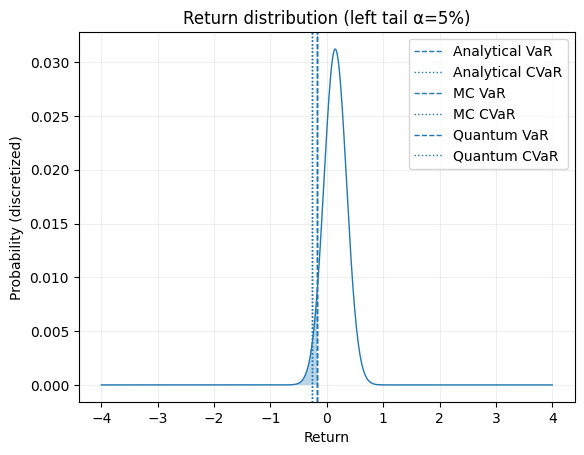

In [12]:
def plot_distribution_with_tail(grid_r, probs, alpha, var_vals, cvar_vals, labels):
    # Convert probs on grid into a pseudo-pdf for plotting (up to a scale factor)
    # (fine for visualization only)
    fig = plt.figure()
    plt.plot(grid_r, probs, linewidth=1)

    for v, c, lab in zip(var_vals, cvar_vals, labels):
        plt.axvline(v, linestyle='--', linewidth=1, label=f"{lab} VaR")
        plt.axvline(c, linestyle=':', linewidth=1, label=f"{lab} CVaR")

    # Shade left tail up to (analytical) VaR just for visual clarity
    var_ref = var_vals[0]
    mask = grid_r <= var_ref
    plt.fill_between(grid_r[mask], probs[mask], alpha=0.3, step='pre')

    plt.title(f"Return distribution (left tail α={alpha:.0%})")
    plt.xlabel("Return")
    plt.ylabel("Probability (discretized)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

var_vals = [var_a, var_mc, var_q]
cvar_vals = [cvar_a, cvar_mc, cvar_q]
labels = ["Analytical", "MC", "Quantum"]

plot_distribution_with_tail(grid_r, probs, ALPHA_DEFAULT, var_vals, cvar_vals, labels)

## 6) Benchmark: CVaR vs QSP polynomial degree



In [ ]:
degree_list = [9, 13, 17, 21, 25, 31]

rows = []
for deg in degree_list:
    i, v, p_disc, post_frac, c_est, max_err, min_ov, _ = estimate_cvar_quantum_qsp(
        alpha=ALPHA_DEFAULT,
        degree=deg,
        shots=NUM_SHOTS_DEFAULT,
    )
    rows.append((deg, i, v, c_est, p_disc, post_frac, max_err, min_ov))

rows


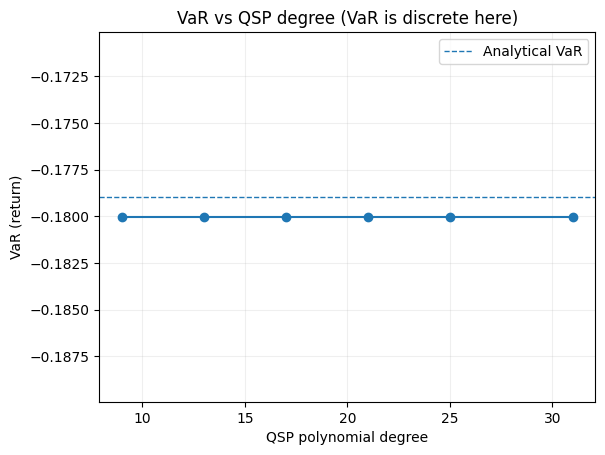

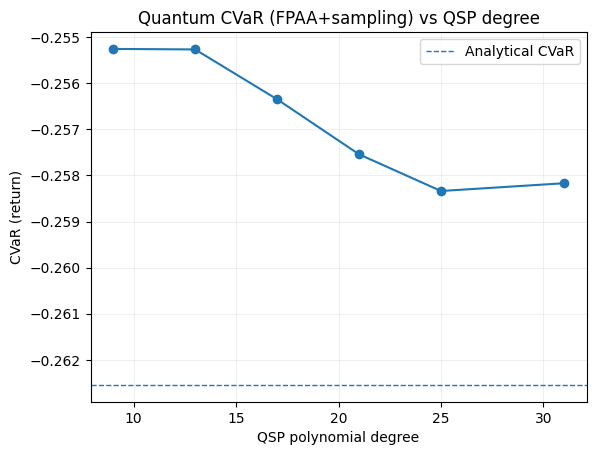

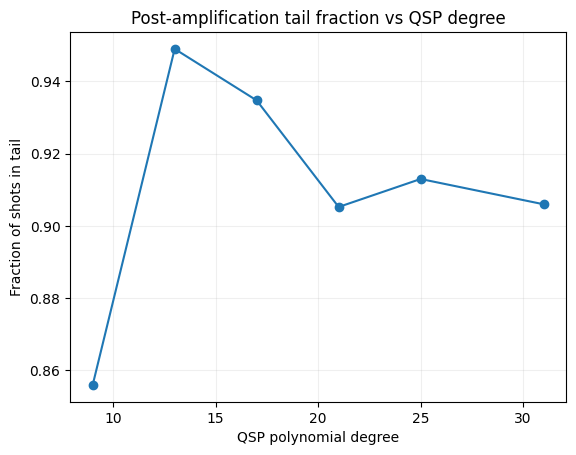

In [ ]:
deg_arr = np.array([r[0] for r in rows])
var_arr = np.array([r[2] for r in rows])
cvar_arr = np.array([r[3] for r in rows])
post_frac_arr = np.array([r[5] for r in rows])

# VaR vs degree (should be constant, since VaR index is discrete/ deterministic here)
plt.figure()
plt.plot(deg_arr, var_arr, marker='o')
plt.axhline(var_a, linestyle='--', linewidth=1, label="Analytical VaR")
plt.title("VaR vs QSP degree (VaR is discrete here)")
plt.xlabel("QSP polynomial degree")
plt.ylabel("VaR (return)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

# CVaR vs degree
plt.figure()
plt.plot(deg_arr, cvar_arr, marker='o')
plt.axhline(cvar_a, linestyle='--', linewidth=1, label="Analytical CVaR")
plt.title("Quantum CVaR (FPAA+sampling) vs QSP degree")
plt.xlabel("QSP polynomial degree")
plt.ylabel("CVaR (return)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

# Tail fraction after amplification (diagnostic)
plt.figure()
plt.plot(deg_arr, post_frac_arr, marker='o')
plt.title("Post-amplification tail fraction vs QSP degree")
plt.xlabel("QSP polynomial degree")
plt.ylabel("Fraction of shots in tail")
plt.grid(True, alpha=0.2)
plt.show()


## 7) Sensitivity to confidence level (alpha sweep)



In [ ]:
confidence_levels = [0.90, 0.95, 0.975, 0.99]
alpha_list = [1.0 - cl for cl in confidence_levels]

# Fix QSP degree for this sweep
DEGREE_SWEEP = DEGREE_DEFAULT

results = []
for cl, alpha in zip(confidence_levels, alpha_list):
    varA, cvarA = analytical_var_cvar_normal(mu, sigma, alpha)
    varM, varM_sd, cvarM, cvarM_sd = mc_var_cvar(mu, sigma, alpha, rng=rng)

    iQ, varQ, p_disc, post_frac, cvarQ, qsp_err, min_ov, deg = estimate_cvar_quantum_qsp(
        alpha=alpha,
        degree=DEGREE_SWEEP,
        shots=NUM_SHOTS_DEFAULT,
    )

    results.append((cl, alpha, varA, cvarA, varM, varM_sd, cvarM, cvarM_sd, varQ, cvarQ, p_disc, post_frac))

results


[(0.9,
  0.09999999999999998,
  -0.10631031310892011,
  -0.2009966638649738,
  -0.10646066207688087,
  0.0007917840157869717,
  -0.20123375125487283,
  0.0008600745463131605,
  -0.10176125244618417,
  -0.1906272644231109,
  0.1112364453926177,
  0.90675),
 (0.95,
  0.050000000000000044,
  -0.17897072539029443,
  -0.26254256150148547,
  -0.17931079680480527,
  0.0008016945432389695,
  -0.26305783709883884,
  0.0011253241039239708,
  -0.18003913894324874,
  -0.2548432693554559,
  0.05353885256663524,
  0.90925),
 (0.975,
  0.025000000000000022,
  -0.24199279690801082,
  -0.31756055844028264,
  -0.24221169296516432,
  0.0011418806416549924,
  -0.31756766395961133,
  0.0017129319634033708,
  -0.2426614481409004,
  -0.31045877199723376,
  0.02713597101859823,
  0.9295),
 (0.99,
  0.010000000000000009,
  -0.3152695748081682,
  -0.3830428440691611,
  -0.31596415207641404,
  0.0016332594993773957,
  -0.3836340020640499,
  0.0017584202569568119,
  -0.320939334637965,
  -0.3819392819219612,
  0.

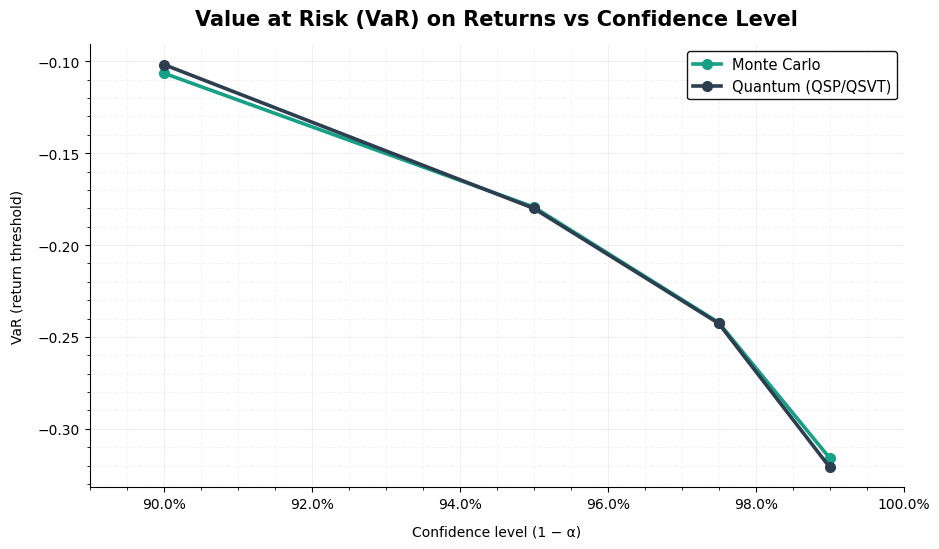

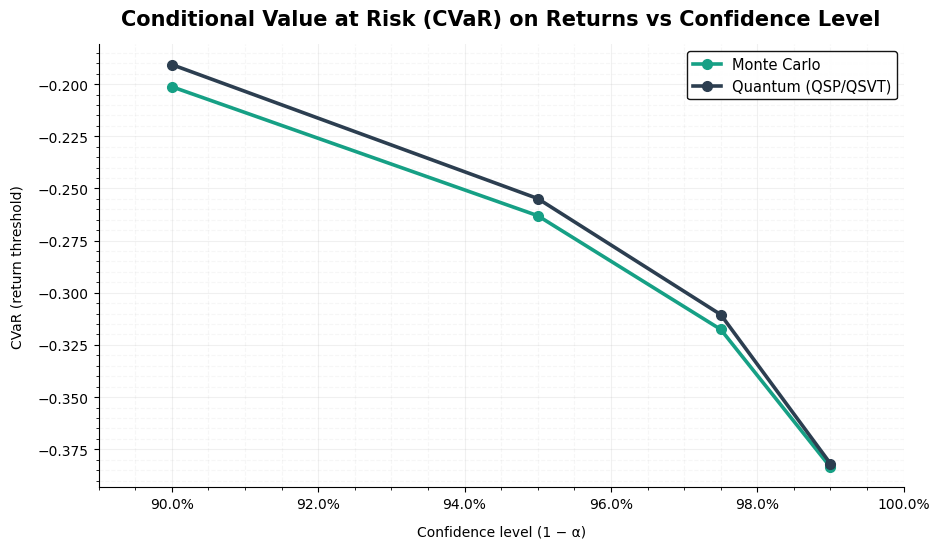

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
results = [(0.9,
  0.09999999999999998,
  -0.10631031310892011,
  -0.2009966638649738,
  -0.10646066207688087,
  0.0007917840157869717,
  -0.20123375125487283,
  0.0008600745463131605,
  -0.10176125244618417,
  -0.1906272644231109,
  0.1112364453926177,
  0.90675),
 (0.95,
  0.050000000000000044,
  -0.17897072539029443,
  -0.26254256150148547,
  -0.17931079680480527,
  0.0008016945432389695,
  -0.26305783709883884,
  0.0011253241039239708,
  -0.18003913894324874,
  -0.2548432693554559,
  0.05353885256663524,
  0.90925),
 (0.975,
  0.025000000000000022,
  -0.24199279690801082,
  -0.31756055844028264,
  -0.24221169296516432,
  0.0011418806416549924,
  -0.31756766395961133,
  0.0017129319634033708,
  -0.2426614481409004,
  -0.31045877199723376,
  0.02713597101859823,
  0.9295),
 (0.99,
  0.010000000000000009,
  -0.3152695748081682,
  -0.3830428440691611,
  -0.31596415207641404,
  0.0016332594993773957,
  -0.3836340020640499,
  0.0017584202569568119,
  -0.320939334637965,
  -0.3819392819219612,
  0.010275065462014487,
  0.9095)]
# Unpack arrays for plotting
cl_arr = np.array([r[0] for r in results])
alpha_arr = np.array([r[1] for r in results])

varA_arr = np.array([r[2] for r in results])
cvarA_arr = np.array([r[3] for r in results])

varM_arr = np.array([r[4] for r in results])
cvarM_arr = np.array([r[6] for r in results])

varQ_arr = np.array([r[8] for r in results])
cvarQ_arr = np.array([r[9] for r in results])

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

COL_ANALYTICAL = "#c0392b"  # red
COL_MC         = "#16a085"  # green
COL_QUANTUM    = "#2c3e50"  # navy

def plot_vs_confidence(x, yA, yM, yQ, title, ylabel):
    fig, ax = plt.subplots(figsize=(9.5, 5.6))

    
    ax.plot(x, yM, marker="o", linewidth=2.6, markersize=7, color=COL_MC,         label="Monte Carlo")
    ax.plot(x, yQ, marker="o", linewidth=2.6, markersize=7, color=COL_QUANTUM,    label="Quantum (QSP/QSVT)")

    ax.set_title(title, fontsize=15, fontweight="bold", pad=14)
    ax.set_xlabel("Confidence level (1 − α)", labelpad=10)
    ax.set_ylabel(ylabel, labelpad=10)

    # percent formatting if confidence levels are 0..1
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_xlim(min(x) - 0.01, max(x) + 0.01)

    # clean grid + spines
    ax.grid(True, which="major", linestyle="-", alpha=0.18)
    ax.grid(True, which="minor", linestyle="--", alpha=0.10)
    ax.minorticks_on()
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    leg = ax.legend(frameon=True, framealpha=0.92, facecolor="white", edgecolor=(0, 0, 0, 0.08))
    for t in leg.get_texts():
        t.set_fontsize(10.5)

    fig.tight_layout()
    plt.show()

# VaR vs confidence
plot_vs_confidence(
    cl_arr, varA_arr, varM_arr, varQ_arr,
    title="Value at Risk (VaR) on Returns vs Confidence Level",
    ylabel="VaR (return threshold)"
)

# CVaR vs confidence
plot_vs_confidence(
    cl_arr, cvarA_arr, cvarM_arr, cvarQ_arr,
    title="Conditional Value at Risk (CVaR) on Returns vs Confidence Level",
    ylabel="CVaR (return threshold)"
)

